In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Dense, Input, Dropout
from keras._tf_keras.keras.regularizers import l2

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df0 = pd.read_csv('ETH-USD.csv', index_col=0, parse_dates=True)

In [3]:
df = df0[['Close']].copy()

In [4]:
df['LogClose'] = np.log(df['Close'])

In [5]:
df['DiffLogClose'] = df['LogClose'].diff()

In [9]:
len(df)

1828

In [7]:
def build_model(units=50, optimizer='adam', activation='relu',dropout_rate=0.2, regularization_rate=0.01):
    i = Input(shape=(Tx,))
    x = Dense(units, activation=activation)(i)  
    x = Dropout(dropout_rate)(x)  
    x = Dense(units, activation=activation, kernel_regularizer=l2(regularization_rate))(x)  
    x = Dense(Ty)(x) 
    model = Model(inputs=i, outputs=x)
    model.compile(loss='mape', optimizer=optimizer)
    return model

In [8]:
param_grid = {
    'model__units': [32, 64],  
    'model__activation': ['relu', 'tanh'],  
    'model__optimizer': ['adam', 'rmsprop'],  
    'model__dropout_rate': [0.1, 0.2], 
    'model__regularization_rate': [0.01, 0.001], 
    'epochs': [50, 100],
}

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
10/10 - 2s - 245ms/step - loss: 492.2849 - val_loss: 93.9331
Epoch 2/100
10/10 - 0s - 14ms/step - loss: 423.0331 - val_loss: 96.9891
Epoch 3/100
10/10 - 0s - 12ms/step - loss: 318.2841 - val_loss: 99.0718
Epoch 4/100
10/10 - 0s - 13ms/step - loss: 309.6216 - val_loss: 99.9367
Epoch 5/100
10/10 - 0s - 14ms/step - loss: 285.7457 - val_loss: 100.9828
Epoch 6/100
10/10 - 0s - 14ms/step - loss: 266.5518 - val_loss: 100.8833
Epoch 7/100
10/10 - 0s - 12ms/step - loss: 283.1482 - val_loss: 101.0716
Epoch 8/100
10/10 - 0s - 15ms/step - loss: 248.6734 - val_loss: 101.8811
Epoch 9/100
10/10 - 0s - 12ms/step - loss: 256.3982 - val_loss: 102.0611
Epoch 10/100
10/10 - 0s - 12ms/step - loss: 350.0266 - val_loss: 101.8367
Epoch 11/100
10/10 - 0s - 13ms/step - loss: 255.0271 - val_loss: 101.2855
Epoch 12/100
10/10 - 0s - 14ms/step - loss: 251.2644 - val_loss: 100.9148
Epoch 13/100
10/10 - 0s - 13ms/step - loss: 251.2381 - val_los

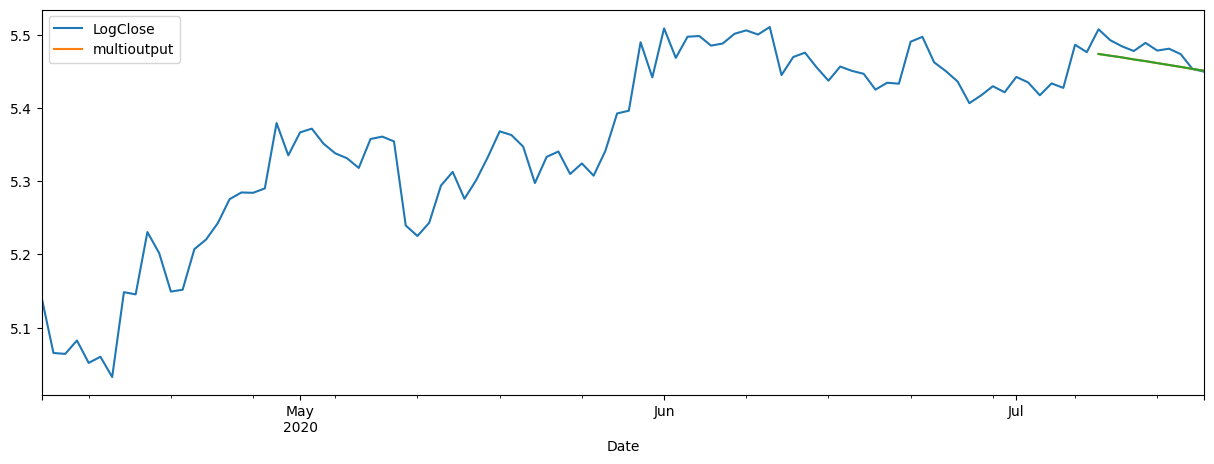

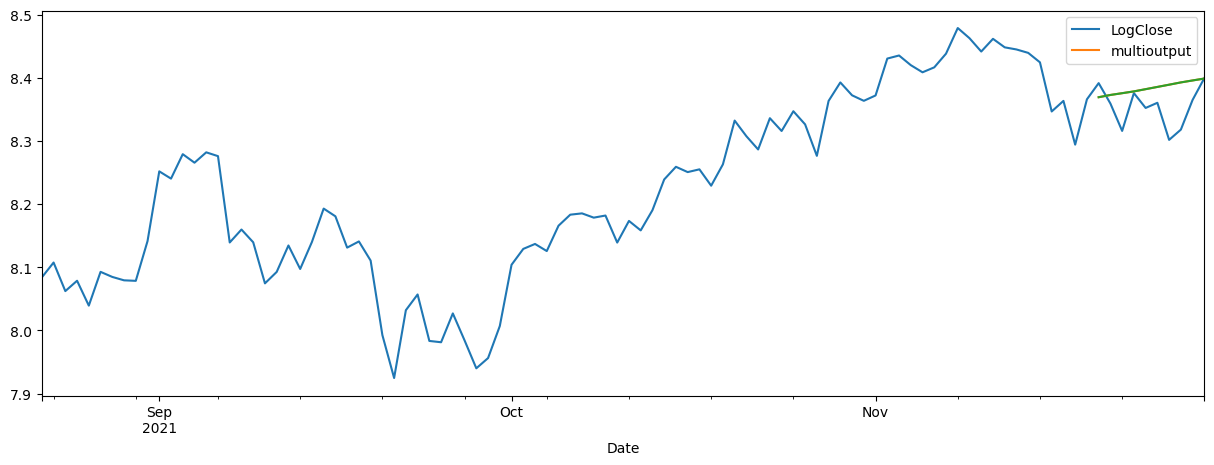

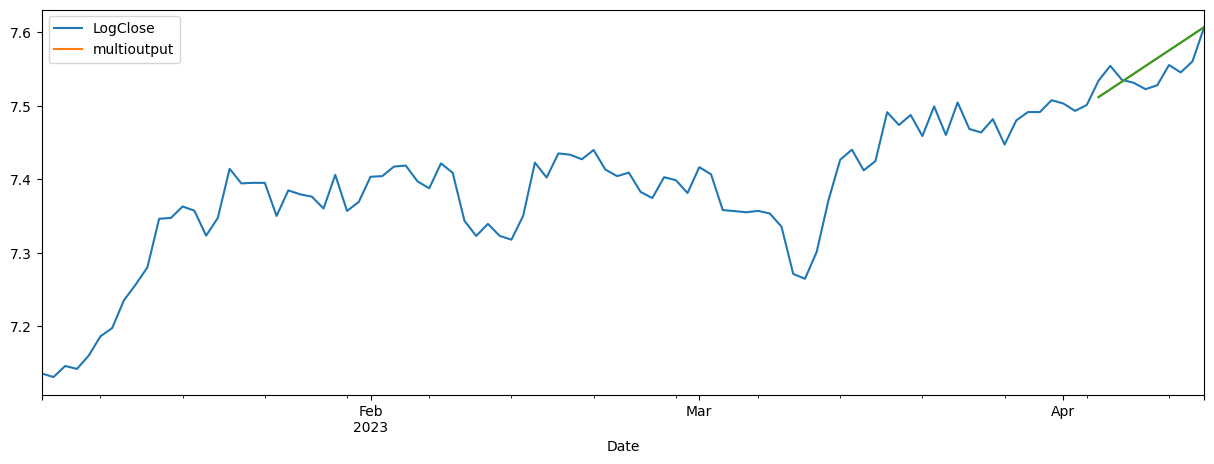

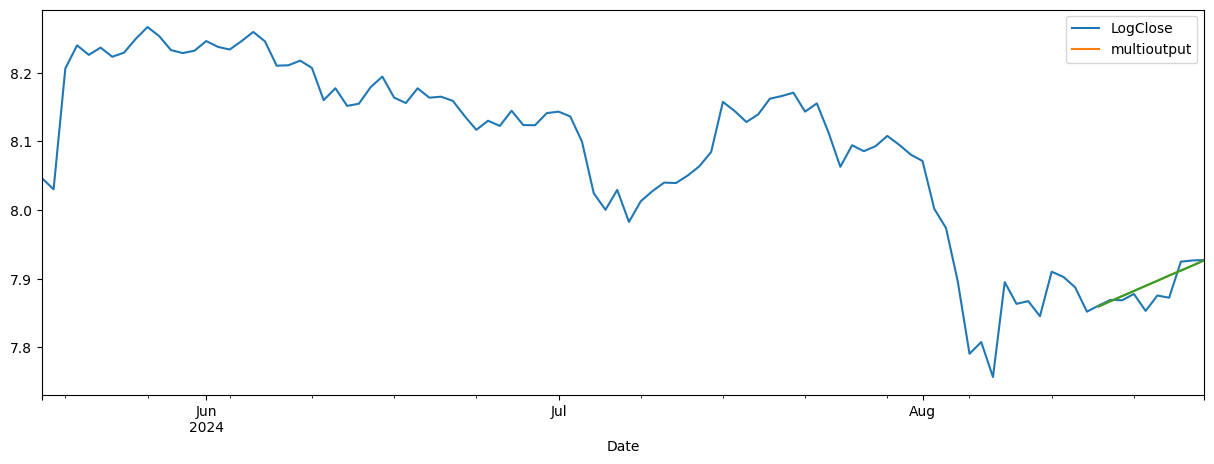

In [13]:
i = 328
real_10d = []
pred_10d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 10
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multioutput']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    pred_10d.append(predicted_temp)
    real_10d.append(real_temp)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
9/9 - 2s - 170ms/step - loss: 969.1830 - val_loss: 132.5942
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 697.7690 - val_loss: 129.3662
Epoch 3/100
9/9 - 0s - 12ms/step - loss: 570.3784 - val_loss: 127.3814
Epoch 4/100
9/9 - 0s - 12ms/step - loss: 654.1790 - val_loss: 125.4765
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 557.0433 - val_loss: 124.2999
Epoch 6/100
9/9 - 0s - 16ms/step - loss: 519.2069 - val_loss: 121.6276
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 471.2484 - val_loss: 120.1362
Epoch 8/100
9/9 - 0s - 12ms/step - loss: 452.8374 - val_loss: 117.1835
Epoch 9/100
9/9 - 0s - 15ms/step - loss: 469.5618 - val_loss: 115.7277
Epoch 10/100
9/9 - 0s - 12ms/step - loss: 422.7886 - val_loss: 115.0447
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 419.0273 - val_loss: 115.0682
Epoch 12/100
9/9 - 0s - 12ms/step - loss: 450.6476 - val_loss: 114.4473
Epoch 13/100
9/9 - 0s - 13ms/step - loss: 438.5812 - val_loss: 114.1634
Epoch 14/1

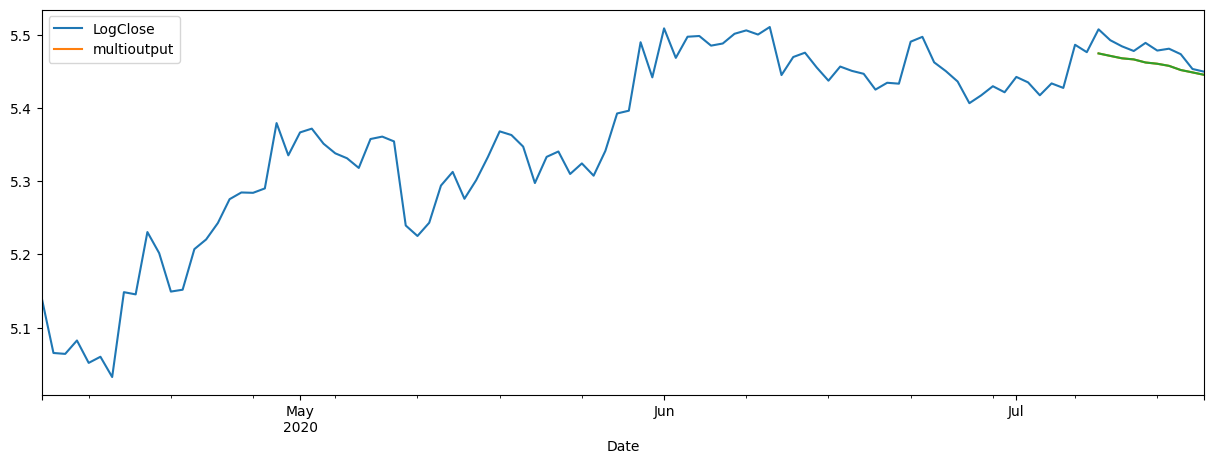

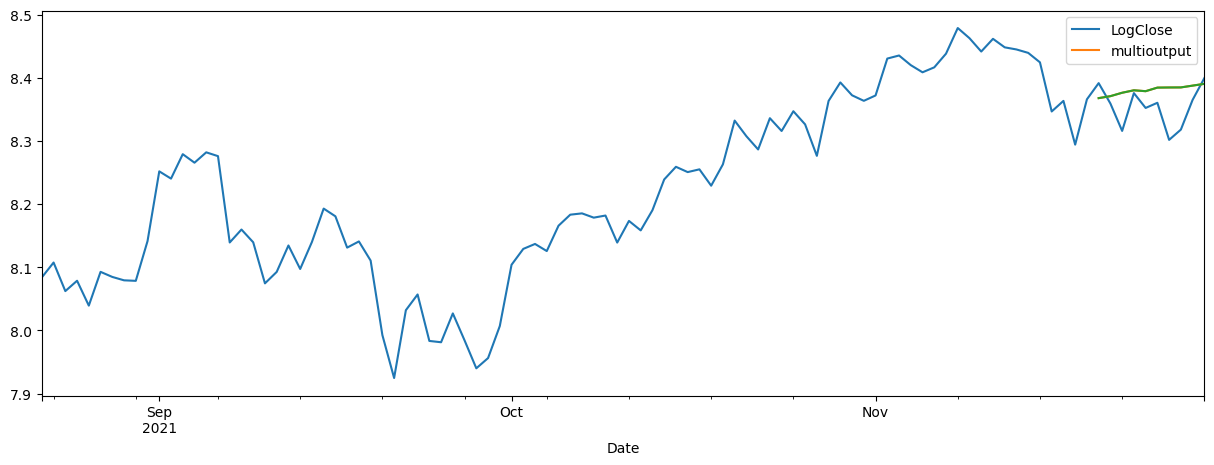

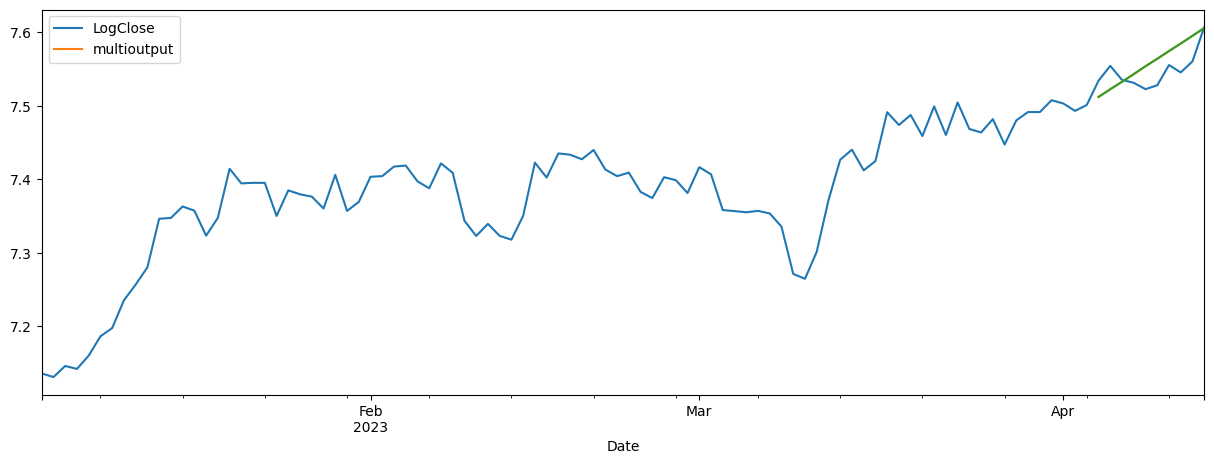

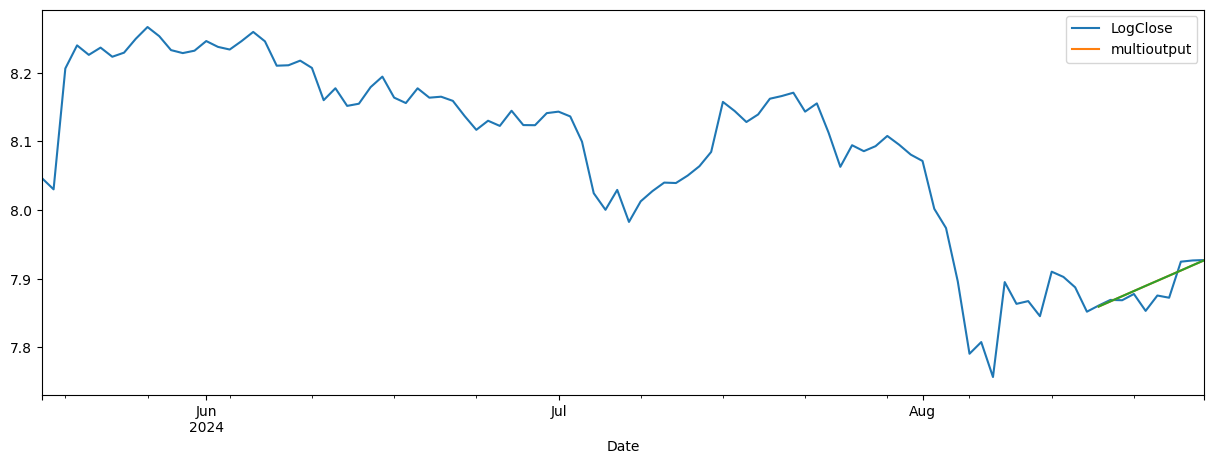

In [28]:
i = 328
real_10d = []
pred_10d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 50
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multioutput']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    pred_10d.append(predicted_temp)
    real_10d.append(real_temp)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
9/9 - 2s - 177ms/step - loss: 753.5103 - val_loss: 109.9879
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 639.7014 - val_loss: 109.3833
Epoch 3/100
9/9 - 0s - 14ms/step - loss: 554.1228 - val_loss: 107.5240
Epoch 4/100
9/9 - 0s - 12ms/step - loss: 467.5383 - val_loss: 106.3532
Epoch 5/100
9/9 - 0s - 14ms/step - loss: 453.3998 - val_loss: 107.0536
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 393.2953 - val_loss: 107.6313
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 434.2999 - val_loss: 108.5143
Epoch 8/100
9/9 - 0s - 12ms/step - loss: 386.5045 - val_loss: 107.2635
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 482.5323 - val_loss: 107.2024
Epoch 10/100
9/9 - 0s - 14ms/step - loss: 351.3134 - val_loss: 107.8294
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 381.2904 - val_loss: 108.4163
Epoch 12/100
9/9 - 0s - 16ms/step - loss: 407.7543 - val_loss: 106.6283
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 370.2208 - val_loss: 107.1490
Epoch 14/1

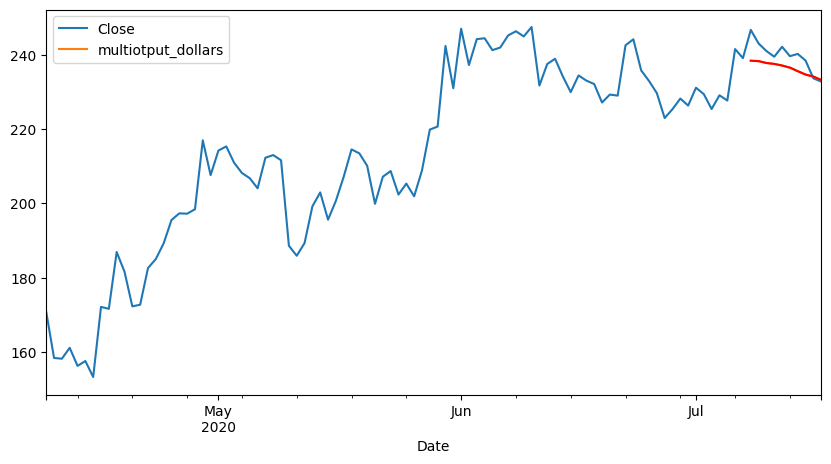

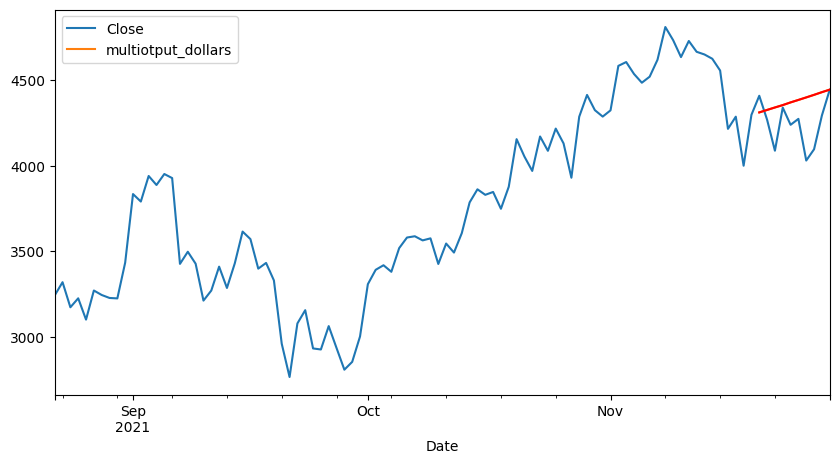

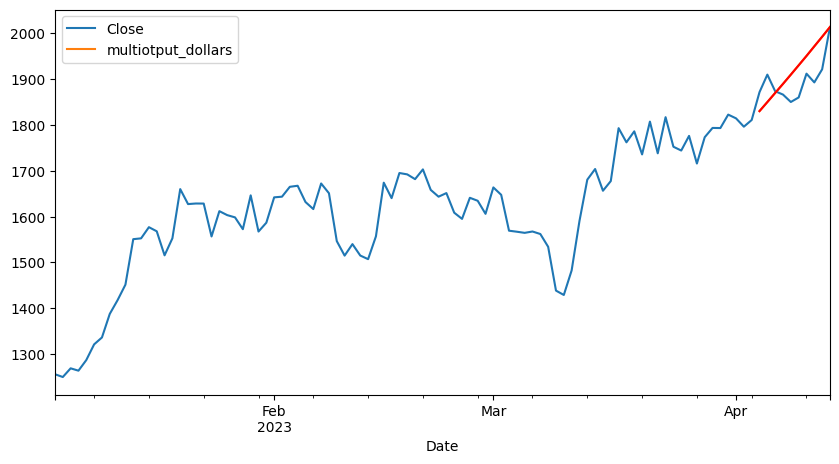

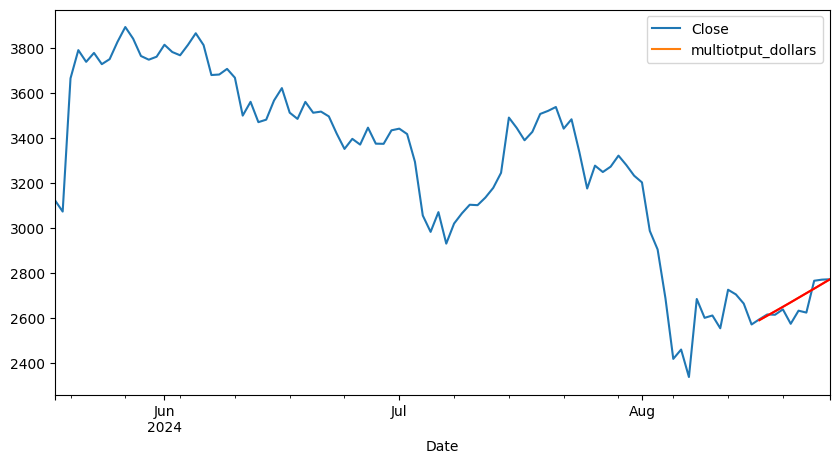

In [10]:
i = 328
real_10d = []
pred_10d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 50
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
        
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.loc[test_idx, 'multiotput_dollars'] = predicted_temp
    
    temp.iloc[-100:][['Close', 'multiotput_dollars']].plot(figsize=(10, 5))
    plt.plot(temp.loc[test_idx, 'multiotput_dollars'],color='red')
    plt.legend()
    
    pred_10d.append(predicted_temp)
    real_10d.append(real_temp)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
7/7 - 1s - 175ms/step - loss: 1074.7493 - val_loss: 116.6062
Epoch 2/100
7/7 - 0s - 12ms/step - loss: 814.6149 - val_loss: 113.0841
Epoch 3/100
7/7 - 0s - 12ms/step - loss: 813.0886 - val_loss: 108.9807
Epoch 4/100
7/7 - 0s - 11ms/step - loss: 700.8387 - val_loss: 107.3454
Epoch 5/100
7/7 - 0s - 11ms/step - loss: 602.0427 - val_loss: 112.5212
Epoch 6/100
7/7 - 0s - 12ms/step - loss: 528.2162 - val_loss: 111.4189
Epoch 7/100
7/7 - 0s - 13ms/step - loss: 657.1554 - val_loss: 107.4249
Epoch 8/100
7/7 - 0s - 10ms/step - loss: 582.3040 - val_loss: 109.4964
Epoch 9/100
7/7 - 0s - 12ms/step - loss: 518.4755 - val_loss: 105.8616
Epoch 10/100
7/7 - 0s - 11ms/step - loss: 505.5750 - val_loss: 104.4478
Epoch 11/100
7/7 - 0s - 12ms/step - loss: 500.4676 - val_loss: 105.3514
Epoch 12/100
7/7 - 0s - 10ms/step - loss: 441.3805 - val_loss: 107.7320
Epoch 13/100
7/7 - 0s - 10ms/step - loss: 437.3084 - val_loss: 103.8197
Epoch 14/

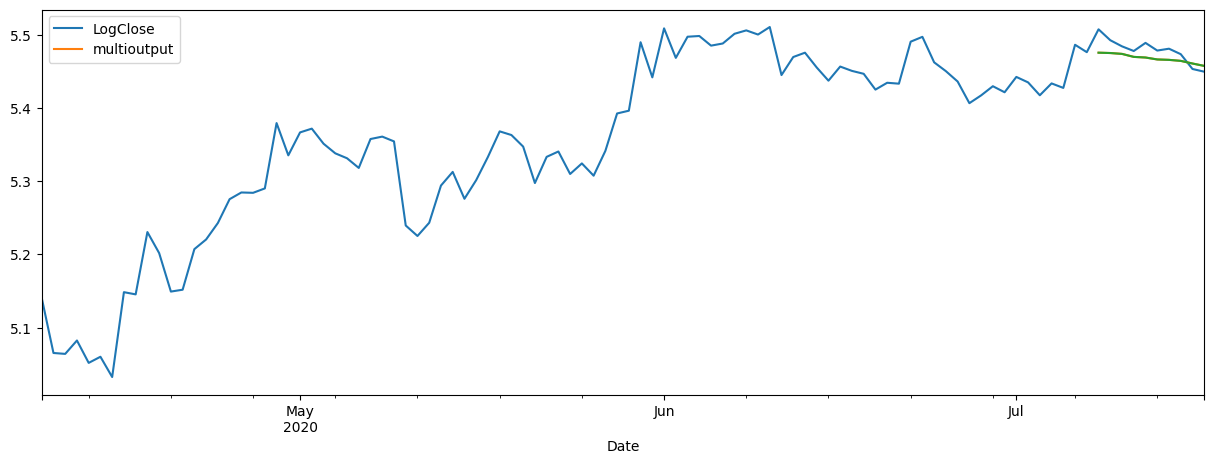

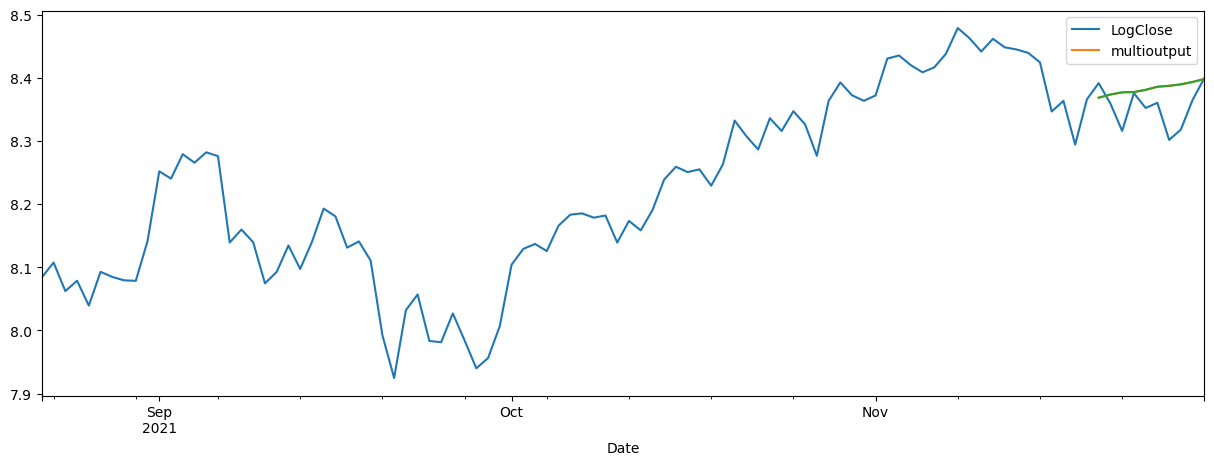

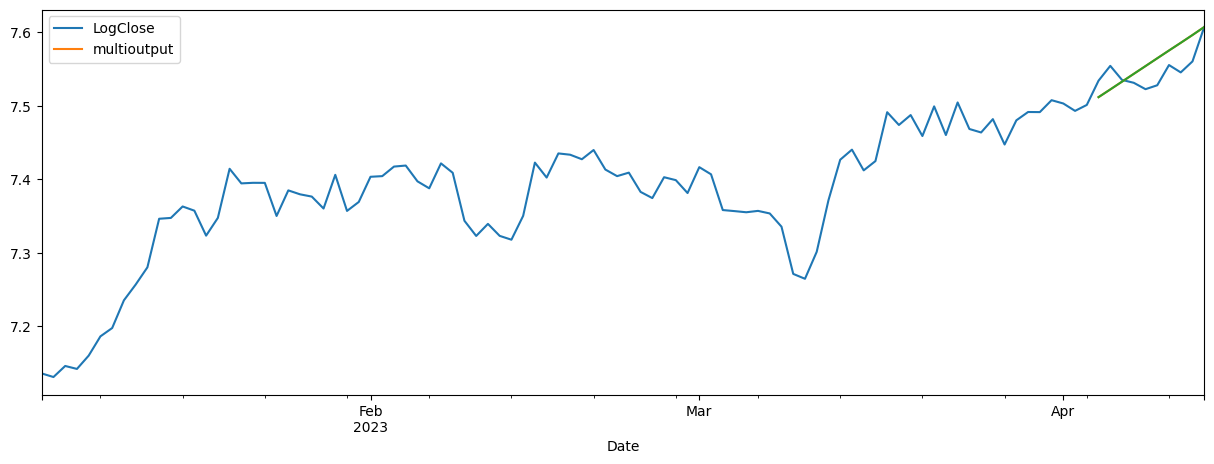

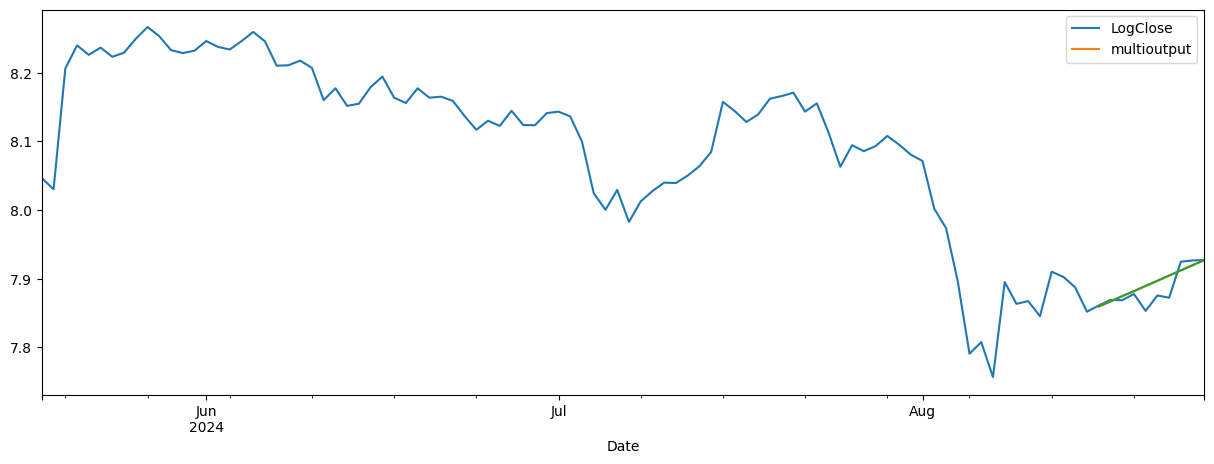

In [35]:
i = 328
real_10d = []
pred_10d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 100
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multioutput']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    pred_10d.append(predicted_temp)
    real_10d.append(real_temp)

In [14]:
predicted_10d = pred_10d
real_10d = real_10d

In [29]:
predicted_50d = pred_10d
real_50d = real_10d

In [36]:
predicted_100d = pred_10d
real_100d = real_10d

In [17]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [37]:
print("R2 score for 10, 50 and 100 days are:",round(r2_score(real_10d, predicted_10d),4), round(r2_score(real_50d, predicted_50d),4),round(r2_score(real_100d, predicted_100d),4))

R2 score for 10, 50 and 100 days are: 0.9948 0.9953 0.995


In [38]:
print("MAPE score for 10, 50 and 100 days are:",round(mean_absolute_percentage_error(real_10d, predicted_10d)*100,2),round(mean_absolute_percentage_error(real_50d, predicted_50d)*100,2),round(mean_absolute_percentage_error(real_100d, predicted_100d)*100,2))

MAPE score for 10, 50 and 100 days are: 2.2 2.19 2.12


In [39]:
print("MAE scores for 10, 50 and 100 days are:",round(mean_absolute_error(real_10d, predicted_10d),2),round(mean_absolute_error(real_50d, predicted_50d),2),round(mean_absolute_error(real_100d, predicted_100d),2))

MAE scores for 10, 50 and 100 days are: 57.36 55.68 56.5


In [40]:
print("MSE scores for 10, 50 and 100 days are:",round(mean_squared_error(real_10d, predicted_10d),2),round(mean_squared_error(real_50d, predicted_50d),2),round(mean_squared_error(real_100d, predicted_100d),2))

MSE scores for 10, 50 and 100 days are: 10204.76 9074.71 9850.44


In [41]:
print("RMSE scores for 10, 50 and 100 days are:",round(root_mean_squared_error(real_10d, predicted_10d),2),round(root_mean_squared_error(real_50d, predicted_50d),2),round(root_mean_squared_error(real_100d, predicted_100d),2))

RMSE scores for 10, 50 and 100 days are: 82.41 79.58 81.37
